The aim of this notebook is to generate coefficients for the polynomial approximation of the Taylor series (about $x=0$) for the composition of the Gaussian function with Arcsin.

Recall that we define the Gaussian as $$g_\sigma(x) = {\rm e}^{-\frac{x^2}{2\sigma^2}}$$ and therefore, $$g_\sigma(\arcsin(x)) = {\rm e}^{-\frac{\arcsin(x)^2}{2\sigma^2}}$$


---


The Taylor expansion of $\arcsin(x)$ about $x=0$ is given by:
$$\arcsin(x) = \sum_{n=0}^{\infty} s_n x^{2n}$$ where $$s_n = \frac{1}{2^{2n}}\binom{2n}{n} \frac{1}{2n+1}$$

It can be shown that the Taylor series of our target function is: $$f(x) = 1+ \sum_{n=1}^{\infty} c_n x^{2n}$$ where $$c_n = \frac{1}{n!} B_{n}(g_0,2!g_1,\ldots,n!g_{n-1})$$
The $n$-th complete Bell polynomials are represented as $B_n$ and the variable $g_m$ is related to a normalised Cuachy product from the $\arcsin(x)$ Taylor series.


---
**Truncated Polynomial**

We cannot evaluate an infinite series so we truncate.
Let $$P_d(x) = 1 + \sum_{n=1}^{d} c_d x^{2d}$$ be a degree-$2d$ polynomial.

We also want a series expansion in terms of the Chebyshev polynomials.

In [2]:
import numpy as np
import math
from sympy import bell, symbols
import json
from numpy.polynomial import Polynomial, chebyshev

class TargetSeriesCoefficients:
    """
    A class to compute coefficients for the series expansion of the target function:
        F(x) = Exp[ - 1/(2*sigma^2) * arcsin(x)^2 ].

    The class supports two primary bases for the Taylor series expansions about x=0:

    1.  **Standard Polynomial Taylor Series (P_d(x)):**
        Represented as a truncated polynomial:
        P_d(x) = 1 + sum_{n=1}^{d} c_n * x^(2n)
        Where 'd' is the maximum degree.
        The coefficients 'c_n' are computed using Bell polynomials.
        (We refer to the Standard Polynomial series as "Taylor" series in the context of this class).

    2.  **Chebyshev Series of the First Kind (T_n(x)):**
        Represented as:
        Q_d(x) = sum_{n=0}^{d} l_n * T_{2n}(x)
        Where 'd' is the maximum degree and 'l_n' are the Chebyshev coefficients.
        Note that only even-indexed Chebyshev polynomials (T_0, T_2, T_4, ...) are used due to the even nature of the target function's Taylor expansion.
        The conversion from Taylor to Chebyshev coefficients involves pre-computed Chebyshev coefficient arrays loaded from 'cheby_coeffs.json'.

    **Key Assumptions & Conventions:**
    * **Input Range for x:** While not explicitly enforced by methods, the arcsin(x) function
        is real-valued for x in [-1, 1]. The series expansions are generally valid within this range.
    * **Coefficient Ordering:** All lists/arrays of coefficients (e.g., `c_n`, `l_n`) are ordered by increasing degree.
        For a list representing coefficients up to degree 'D', the element at index `i` corresponds to the coefficient of the either x^(2i) for Standard Polynomial series or T_{2i}(x) for Chebyshev series.
    * **Implied Zeros for Odd Powers:** For Standard Polynomial and Chebyshev expansions where only even powers/polynomials appear (e.g., x^0, x^2, x^4, ... or T_0, T_2, T_4, ...), the coefficient lists directly store c_0, c_1, c_2, ... or l_0, l_1, l_2, ...
        The `insert_zeros_loop` static method is used internally to convert these compressed lists into the standard format expected by `numpy.polynomial.Polynomial` and `numpy.polynomial.chebyshev.Chebyshev` objects, which require explicit zeros for missing odd powers.
    * **cheby_coeffs.json:** This file is expected to exist in the same directory as the script and contain pre-computed Chebyshev coefficients.
        Its structure is assumed to be a dictionary or list where relevant coefficients can be accessed by integer (or string representation of integer) keys/indices.
        (Further detail on its structure should be given under the relevant methods).

    **Usage:**
    To use this class, instantiate it with a positive sigma value, then call methods to compute Taylor or Chebyshev coefficients as needed.
    """
    # ... rest of your class code
    def __init__(self, sigma=1):
        if sigma <= 0:
            raise ValueError("Sigma must be positive.")
        self.sigma = sigma

    def insert_zeros_loop(self, original_list):
        """
        Inserts a zero after each element in the original list, except for the last element.
        """
        new_list = []
        for i, item in enumerate(original_list):
            new_list.append(item)
            if i < len(original_list) - 1: # Don't add a zero after the last element
                new_list.append(0)
        return new_list

    def TargetFunction(self, x):
      """
      Returns the target function value for a given input x.
      """
      return np.exp( - (1/(2 * self.sigma**2)) * (np.arcsin(x))**2)

    def ArcsineTaylorCoeffs(self, n: int):
        """
        Takes a non-negative integer n and returns the n-th order coefficient of the Taylor series expansion of arcsine.
            arcsine(x) = \sum_{n=0}^{\infty} s_n x^{2n+1}
        Args:
            n (int): The order of the coefficient to return.
        Returns:
            float: The n-th order coefficient of the Taylor series expansion of arcsine.

        Note:
            arcsine has an odd order expansion, so coefficient n corresponds to the term of order 2n+1.
        """
        if n < 0:
            raise ValueError("n must be non-negative.")

        return (1/(2**(2*n)))*math.comb(2*n,n)*(1/(2*n+1))

    def ArcsineCauchyCoeffs(self, m: int):
        """
        Computes the m-th order coefficient of the Cauchy product of arcsine with itself.
        The Cauchy product of arcsin(x)^2 is given by:
            arcsin(x) * arcsin(x) = \sum_{m=0}^{\infty} u_m x^{2m+2}
            u_m = \sum_{j=0}^{m} s_j * s_{m-j}.
        Args:
            m (int): The order of the coefficient to return.
        Returns:
            float: The m-th order coefficient of the Cauchy product of arcsine with itself.
        """
        if m < 0:
            raise ValueError("m must be non-negative.")
        total_sum = 0
        for j in range(m+1):  # Loop from j = 0 to m
            first_term = self.ArcsineTaylorCoeffs(j)
            second_term = self.ArcsineTaylorCoeffs(m - j)
            total_sum += first_term * second_term

        return total_sum

    def ScaledArcsineCauchyCoeffs(self, m: int):
        """
        Scaled version of the Cauchy coefficients for arcsine, scaled by -1/(2*sigma^2).
        """
        return (-2*(self.sigma**2))**(-1) * self.ArcsineCauchyCoeffs(m)

    def TargetTaylorCoeff(self, n: int):
        """
        Computes the n-th coefficient of the Taylor series expansion of the target function about x=0.
        The coefficients are defined using the n-th complete Bell polynomial:
            c_n = \frac{1}{n!} B_{n}(1! * g(0), 2! * g(1), \dots, (n)! * g(n-1))
            g(m) = -\frac{1}{2\sigma^2} u_m and u_m is the m-th Cauchy coefficient of arcsine.
        The n-th complete Bell polynomial is a sum over n many partial Bell polynomials:
            B_{n}(x_1, x_2, \dots, x_n) = \sum_{k=1}^{n} B_{n,k}(x_1, x_2, \dots, x_n)
        Args:
            n (int): The order of the coefficient to return.
        Returns:
            tuple: A tuple containing the n-th coefficient and a string representation of the coefficient.
        """
        if n < 1:
            raise ValueError("n must be at least 1")

        total_sum = 0
        vars = symbols(f'x:{n}')

        # Create a dictionary for substitution: {x0: 1! * u(0), x2: 2! * u(2), ...}
        subs_s = {vars[i]: math.factorial(i+1) * self.ScaledArcsineCauchyCoeffs(i) for i in range(n)}
        # print(f"subs_s: {subs_s}\n")

        for k in range(1,n +1):
            num_vars = n - k + 1
            sym_vars = vars[:num_vars]
            # print(f"n: {n}, k: {k}, vars: {sym_vars}, num_vars: {num_vars}")
            kth_partial_bell = bell(n,k,sym_vars)
            # print(f"kth_partial_bell: {kth_partial_bell}\n")

            # Perform the substitution and evaluate
            result_k = kth_partial_bell.subs(subs_s)
            # print(f"result_k: {result_k}\n")
            total_sum += result_k

        result = (1/math.factorial(n)) * total_sum
        output = f"{n}-th coefficient (~ x^{2*n}): c_{n} = {result}"
        return result, output

    def ListTargetTaylorCoeff(self, max_degree: int, full: bool=False):
        """
        Produces a list of coefficients for the Taylor series expansion of the target function about x=0, up to the specified max_degree.
        Args:
            max_degree (int): The maximum degree of the Taylor series expansion.
            full (bool): If True, the list will include zeros for odd powers.
        Returns:
            list: A list of coefficients for the Taylor series expansion.
        Note:
            The i-th element of the list corresponds to the coefficient c_i for the term x^(2i).
            All coefficient lists start from c_0 and go up to c_max_degree.
        ---
        Example:
        (Example list not necessarily representative of actual output, just for illustration)
        >>> D = TargetSeriesCoefficients(sigma=1)
        >>> D.ListTargetTaylorCoeff(3)
        [1,2,3,4]

        -> c_0 = 1, c_1 = 2, c_2 = 3, c_3 = 4
        -> The polynomial is: 1 + 2x^2 + 3x^4 + 4x^6
        """
        output_list = [1] + [float(self.TargetTaylorCoeff(i)[0]) for i in range(1,max_degree+1)]
        if full==True:
            return self.insert_zeros_loop(output_list)
        else:
            return output_list

    def ChebyCoeff(self, degree: int):
        """
        Reads in the Chebyshev polynomial coefficients from a JSON file and returns the coefficients for the degree-th order Chebyshev polynomial of the first kind.
        Args:
            degree (int): The order of the Chebyshev polynomial to return coefficients for.
        Returns:
            list: A list of coefficients for the Chebyshev polynomial of the first kind of order degree.
        Note:
            The input degree must be a multiple of 2.
            The coefficients are stored in a JSON file named 'cheby_coeffs.json'.
            All coefficient lists start from t_0 and go up to t_degree.
        ---
        Example:
        (Example list not necessarily representative of actual output, just for illustration)
        >>> D = TargetSeriesCoefficients(sigma=1)
        >>> D.ChebyCoeff(4)
        [1,-8,8]

        -> t_0 = 1, t_2 = 2, t_4 = 3
        -> The polynomial is: 1 + -8x^2 + 8x^4 = T_4(x)
        """
        if degree < 0 or degree % 2 != 0:
            raise ValueError("degree must be a non-negative even integer.")

        with open('cheby_coeffs.json', 'r') as f:
            coeffs = json.load(f)

        return coeffs[int(degree/2)]

    def ListChebyCoeff(self, max_degree: int):
        """
        Returns a list of coefficient arrays for Chebyshev polynomials of the first kind from degree-0 to degree-max_degree in steps of 2.
        Args:
            max_degree (int): The maximum order of the Chebyshev polynomial.
        Returns:
            list: A list of coefficient arrays for Chebyshev polynomials of the first kind.
        Note:
            The l-th array in the list corresponds to the coefficients for the Chebyshev polynomial of order (2l).
            The i-th element of the l-th array corresponds to the coefficient for x^2i in the Chebyshev polynomial of order (2l).
        ---
        Example:
        (Example list not necessarily representative of actual output, just for illustration)
        >>> D = TargetSeriesCoefficients(sigma=1)
        >>> D.ListChebyCoeff(4)
        [[1], [-1, 2], [1, -8, 8]]

        -> The first array corresponds to T_0(x) = 1
        -> The second array corresponds to T_2(x) = -1 + 2x^2
        -> The third array corresponds to T_4(x) = 1 - 8x^2 + 8x^4
        """
        with open('cheby_coeffs.json', 'r') as f:
            coeffs = json.load(f)

        return coeffs[:int(max_degree/2)+1]

    def ListTargetChebyCoeff(self, max_degree: int, full: bool=False):
        """
        Produces a list of coefficients for the Chebyshev polynomial decomposition of the target function P_d(x).
        \sum_{n=0}^{d} c_n x^{2n} = \sum_{n=0}^{d} l_n T_{2n}(x)
        l_n = \frac{1}{t^{(2n)}_n} (c_n - \sum_{m=n+1}^{d} l_m t^{(2n)}_m)
        where t^{(2n)}_m is the m-th coefficient of the Chebyshev polynomial of order (2n).
        Args:
            max_degree (int): The maximum degree of the Chebyshev polynomial decomposition.
            full (bool): If True, the list will include zeros for odd powers.
        Returns:
            list: A list of coefficients for the Chebyshev polynomial decomposition of the target function.
        Note:
            The i-th element of the list corresponds to the coefficient for the Chebyshev polynomial of degree (2i)
            All coefficient lists start from l_0 and go up to l_max_degree.
        ---
        Example:
        (Example list not necessarily representative of actual output, just for illustration)
        >>> D = TargetSeriesCoefficients(sigma=1)
        >>> D.ListTargetChebyCoeff(4)
        [1,-2,3,-4,5]

        -> l_0 = 1, l_1 = -2, l_2 = 3, l_3 = -4, l_4 = 5
        -> The polynomial is: 1 - 2T_2(x) + 3T_4(x) - 4T_6(x) + 5T_8(x)
        -> This is equivalent to the Taylor series expansion of the target function up to degree 8.
        """
        taylor_coeff_list = self.ListTargetTaylorCoeff(max_degree)

        if len(taylor_coeff_list) != max_degree+1:
            raise ValueError(f"taylor_coeff_list must be of length {n+1}")

        cheby_coeff_list = [0] * (max_degree+1)
        # print(f"cheby_coeff_list: {cheby_coeff_list}")

        cheby_coeff_max = taylor_coeff_list[max_degree] / self.ChebyCoeff(2*max_degree)[max_degree]
        cheby_coeff_list[max_degree] = cheby_coeff_max
        # print(f"cheby_coeff_list: {cheby_coeff_list}")

        for k in range(max_degree-1,-1,-1): # Count in reverse
            # print(f"k = {k}")
            tail_sum = 0
            for m in range(k+1,max_degree+1):
                # print(f"For k={k}: m={m} and cheby_coeff_list[{m}]={cheby_coeff_list[m]} and ChebyCoeff({2*m})[{k}]={ChebyCoeff(2*m)[k]}")
                scaled_coeff = cheby_coeff_list[m] * self.ChebyCoeff(2*m)[k]
                # print(f"scaled_coeff = {scaled_coeff}")
                tail_sum += scaled_coeff
                # print(f"tail_sum = {tail_sum}")

            cheby_coeff_k = (taylor_coeff_list[k] - tail_sum) / self.ChebyCoeff(2*k)[k]
            cheby_coeff_list[k] = cheby_coeff_k

        if full==True:
            return self.insert_zeros_loop(cheby_coeff_list)
        else:
            return cheby_coeff_list

    def TargetChebyCoeff(self, max_degree: int, n: int):
        """
        Computes the n-th coefficient of the Taylor series expansion of the target function about x=0 in terms of Chebyshev polynomials.
        Args:
            max_degree (int): The maximum degree of the Chebyshev polynomial decomposition.
            n (int): The index of the coefficient to return.
        Returns:
            float: The n-th coefficient of the Chebyshev polynomial decomposition of the target function P_d(x).
        Note:
            max_degree must be a non-negative even integer.
            We must specify max_degree as this function calls ListTargetChebyCoeff.
        """
        if n < 0:
            raise ValueError("n must be non-negative.")
        if max_degree < 0 or max_degree % 2 != 0:
            raise ValueError("max_degree must be a non-negative even integer.")

        cheby_coeff_list = self.ListTargetChebyCoeff(max_degree)
        if len(cheby_coeff_list) <= n:
            raise ValueError(f"n={n} is out of bounds for the computed coefficients.")

        return cheby_coeff_list[n]

    def CoeffListToPolynomial(self, coeff_list: list, expansion_type: str):
        """
        Converts a list of coefficients into a Polynomial or Chebyshev polynomial object.
        Args:
            coeff_list (list): List of coefficients.
            expansion_type (str): Type of polynomial, either "TAYLOR" or "CHEBYSHEV".
        Returns:
            Polynomial or Chebyshev object based on the expansion_type.
        Note:
            The coefficients in the list should be in ascending order of powers, i.e., the first element corresponds to the constant term (x^0), the second to the coefficient of x^2, and so on.
            Recall that we are dealing with even powers only, so the coefficients for odd powers will be zero and not included in the initial list.
        """
        # Raise error if there is a zero in the input list
        if any(x == 0 for x in coeff_list):
            raise ValueError("The input list must not contain any zeros.")

        if expansion_type == "TAYLOR":
            coeff_list = self.insert_zeros_loop(coeff_list)
            return Polynomial(coeff_list)

        elif expansion_type == "CHEBYSHEV":
            coeff_list = self.insert_zeros_loop(coeff_list)
            return chebyshev.Chebyshev(coeff_list)

        else:
            raise ValueError("expansion_type must be either 'TAYLOR' or 'CHEBYSHEV'")

In [3]:
X = TargetSeriesCoefficients(1)
X.ListTargetChebyCoeff(6)

FileNotFoundError: [Errno 2] No such file or directory: 'cheby_coeffs.json'

In [57]:
X.CoeffListToPolynomial(X.ListTargetChebyCoeff(6),"CHEBYSHEV")

Chebyshev([ 7.16432095e-01,  0.00000000e+00, -2.99151318e-01,  0.00000000e+00,
       -1.89263647e-02,  0.00000000e+00, -3.93404347e-03,  0.00000000e+00,
       -6.63793453e-04,  0.00000000e+00, -7.71631972e-05,  0.00000000e+00,
       -4.46209794e-06], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

Let's plot some graphs!

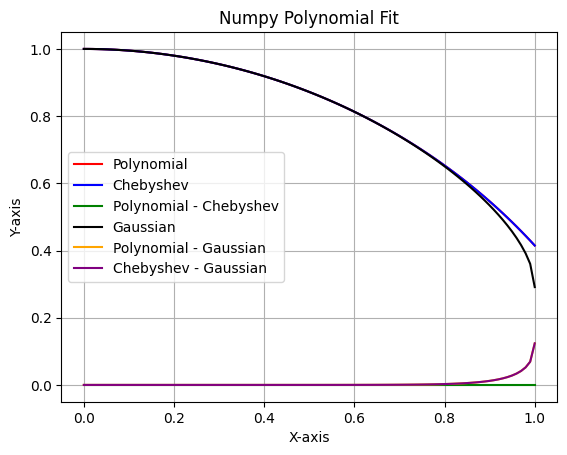

In [2]:
import matplotlib.pyplot as plt

D = TargetSeriesCoefficients(1)

poly_T, poly_C = D.CoeffListToPolynomial(D.ListTargetTaylorCoeff(4),"TAYLOR"), D.CoeffListToPolynomial(D.ListTargetChebyCoeff(4),"CHEBYSHEV")
Gauss_arcin_comp = lambda x: np.exp(-(1/2) * (np.arcsin(x)**2))

x_plot = np.linspace(0, 1, 100)
y_plot_T, y_plot_C, y_plot_G = poly_T(x_plot), poly_C(x_plot), Gauss_arcin_comp(x_plot)
delta_y_TC, delta_y_TG, delta_y_CG = y_plot_T - y_plot_C, y_plot_T - y_plot_G, y_plot_C - y_plot_G

# Recall that the Taylor and Chebyshev expansions are equivalent!

plt.plot(x_plot, y_plot_T, color='red', label=f'Polynomial')
plt.plot(x_plot, y_plot_C, color='blue', label=f'Chebyshev')
plt.plot(x_plot, delta_y_TC, color='green', label=f'Polynomial - Chebyshev')
plt.plot(x_plot, y_plot_G, color='black', label=f'Gaussian')
plt.plot(x_plot, delta_y_TG, color='orange', label=f'Polynomial - Gaussian')
plt.plot(x_plot, delta_y_CG, color='purple', label=f'Chebyshev - Gaussian')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Numpy Polynomial Fit')
plt.legend()
plt.grid(True)
plt.show()

We zoom in on the end of the domain

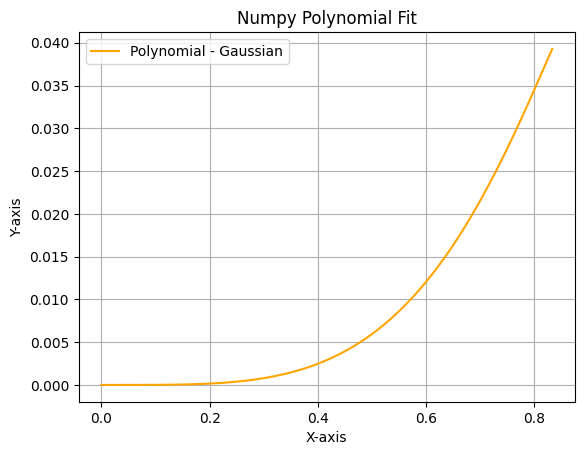

In [44]:
n=6
s=0.75
xs_plot = [float(np.sin(x / 2**n)) for x in range(2**n)]
poly_T = TargetSeriesCoefficients(s).CoeffListToPolynomial(TargetSeriesCoefficients(s).ListTargetTaylorCoeff(1),"TAYLOR")
Gauss_arcin_comp = lambda x: np.exp(-(1/(2*s**2)) * (np.arcsin(x)**2))
ys_plot_T, ys_plot_G = poly_T(xs_plot), Gauss_arcin_comp(xs_plot)
delta_ys_TG = np.abs(ys_plot_T - ys_plot_G)
# plt.plot(xs_plot, ys_plot_T, color='red', label=f'Polynomial')
# plt.plot(xs_plot, ys_plot_G, color='black', label=f'Gaussian')
plt.plot(xs_plot, delta_ys_TG, color='orange', label=f'Polynomial - Gaussian')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Numpy Polynomial Fit')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def DegreeFromError(sigma: float, error: float):
    """
    Computes a lower bound on 2*degree based on the error tolerance and sigma.

    Note:
      Output is rounded up to the nearest even integer.
    """
    return math.ceil((1 / (1-np.sin(1))) * ((np.pi**2 / (8 * sigma**2)) + np.log(1/error))  / 2) * 2

def Alt_DegreeFromError(sigma: float, error: float, n: int):
    """
    Computes a lower bound on 2*degree based on the error tolerance, sigma and the number of qubits.
    Args:
      sigma (float): The standard deviation of the Gaussian.
      error (float): The desired error tolerance.
      n (int): The number of qubits
    Returns:
      int: The estimated 2*degree.

    Note:
      Output is rounded up to the nearest even integer.
    """
    return math.ceil((1 / (1-np.sin((2**n - 1)/(2**n)))) * ((np.pi**2 / (8 * sigma**2)) + np.log(1/error))  / 2) * 2

In [52]:
DegreeFromError(0.75,1e-3)

58

In [47]:
Alt_DegreeFromError(0.75,1e-3,6)

56

In [28]:
def NumericalDegreeFromError(sigma: float, error: float, n: int, initial_degree = None):
    """
    Computes an estimate on 2*degree based on the error tolerance and sigma.
    Args:
      sigma (float): The standard deviation of the Gaussian.
      error (float): The desired error tolerance.
      n (int): The number of qubits
    Returns:
      int: The estimated 2*degree.
    Note:
      For very small error it is good to try guess a smaller initial_degree.
    """
    if initial_degree is None:
      initial_degree = DegreeFromError(sigma, error)

    quarter = 2**(n-2)
    x = [float(np.sin(x / 2**n)) for x in range(2**n)]
    x = x[3*quarter:]
    targ_func = lambda x: np.exp( - (1/(2 * sigma**2)) * (np.arcsin(x))**2)

    d = initial_degree
    delta = 0

    while True:
        init = TargetSeriesCoefficients(sigma=sigma)
        coeff_list = init.ListTargetTaylorCoeff(d // 2)
        poly = init.CoeffListToPolynomial(coeff_list, "TAYLOR")
        delta = np.max(np.abs(poly(x) - targ_func(x)))
        print(f"degree={d} gives delta={delta}")
        if delta <= error:
          # Try a smaller degree
            d -= 2
            if d < 0:
              break
        else:
          # If previous is too small, increment degree
          return d + 2

In [60]:
NumericalDegreeFromError(1,1e-6,6, initial_degree=28)

degree=28 gives delta=2.5676449060374473e-05


30

In [16]:
targ_func = lambda x: np.exp( - (1/(2)) * (np.arcsin(x))**2)
float(targ_func(0.4))

0.9188126343848698